<a href="https://colab.research.google.com/github/thinhngo-x/deep-learning/blob/master/TD6_CNNArchitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup

In [0]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from tqdm.notebook import tqdm

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_first_layer(model):
    filter = model.features[0].weight.cpu().data
    filter = (1/(2*filter.max()))*filter + 0.5 #Normalizing the values to [0,1]
    print(filter.shape)
    imshow(torchvision.utils.make_grid(filter))

In [0]:
def init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

# 1. AlexNet

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


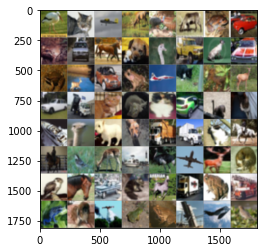

In [0]:
torchvision.transforms.functional.resize
transform = transforms.Compose(
    [
     transforms.Resize(size=(224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
])
     

batch_size = 64

idx_train = np.arange(50000)
np.random.shuffle(idx_train)
idx_train = idx_train[:1000]

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=False,num_workers=2,
                                         sampler=SubsetRandomSampler(idx_train)
                                         )

idx_test = np.arange(10000)
np.random.shuffle(idx_test)
idx_test = idx_train[:1000]

testset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=False,num_workers=2)


def imshow_(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow_(torchvision.utils.make_grid(images))

In [0]:
criterion = nn.CrossEntropyLoss()

def accuracy(net, test_loader, cuda=True):
  net.eval()
  correct = 0
  total = 0
  loss = 0
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          if cuda:
            images = images.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
          outputs = net(images)
          # loss+= criterion(outputs, labels).item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          # if total > 100:
            # break
  net.train()
  print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))
  # return (100.0 * correct / total, loss/total)
  return 100.0 * correct

def train(net, optimizer, train_loader, test_loader, loss,  n_epoch = 5,
          train_acc_period = 100,
          test_acc_period = 5,
          cuda=True):
  loss_train = []
  loss_test = []
  total = 0
  for epoch in range(n_epoch):  # loop over the dataset multiple times
      running_loss = 0.0
      running_acc = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs
          inputs, labels = data
          if cuda:
            inputs = inputs.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
          # print(inputs.shape)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total += labels.size(0)
          # print statistics
          running_loss = 0.33*loss.item()/labels.size(0) + 0.66*running_loss
          _, predicted = torch.max(outputs.data, 1)
          correct = (predicted == labels).sum().item()/labels.size(0)
          running_acc = 0.3*correct + 0.66*running_acc
          if i % train_acc_period == train_acc_period-1:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss))
            print('[%d, %5d] acc: %.3f' %(epoch + 1, i + 1, running_acc))
            running_loss = 0.0
            total = 0
            # break
      if epoch % test_acc_period == test_acc_period-1:
          cur_acc, cur_loss = accuracy(net, test_loader, cuda=cuda)
          print('[%d] loss: %.3f' %(epoch + 1, cur_loss))
          print('[%d] acc: %.3f' %(epoch + 1, cur_acc))
      
  print('Finished Training')

In [0]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(#224
            nn.Conv2d(3, 64, 11, stride=4, padding=2), # 55
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2), # 27
            nn.Conv2d(64, 192, 5, padding=2), # 27
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2), # 13
            nn.Conv2d(192, 384, 3, padding=1), # 13
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, padding=1), # 13
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), # 13
            nn.ReLU(),
		)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [0]:
model_urls = {
'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

def alexnet_classifier(num_classes):
    classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256 * 6 * 6, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(128, 64),
        nn.ReLU(inplace=True),
        nn.Linear(64, num_classes),
    )
    return classifier

def alexnet(num_classes, pretrained=False, **kwargs):
    """AlexNet model architecture from the "One weird trick..." paper.
    Args:
    pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
        for p in model.features.parameters():
            p.requires_grad=False
    classifier = alexnet_classifier(num_classes)
    model.classifier = classifier
    return model

In [0]:
net_no_pretrained = alexnet(num_classes=10, pretrained=False)

#net = AlexNet(10)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net_no_pretrained.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net_no_pretrained.parameters(),lr=learning_rate)
train(net_no_pretrained, optimizer, trainloader, testloader, criterion,  n_epoch = 50,
      train_acc_period = 10,
      test_acc_period = 1000)
accuracy(net_no_pretrained, testloader, cuda=use_cuda)

using cuda
[1,    10] loss: 0.034
[1,    10] acc: 0.152
[2,    10] loss: 0.034
[2,    10] acc: 0.143
[3,    10] loss: 0.033
[3,    10] acc: 0.150
[4,    10] loss: 0.033
[4,    10] acc: 0.191
[5,    10] loss: 0.030
[5,    10] acc: 0.208
[6,    10] loss: 0.032
[6,    10] acc: 0.173
[7,    10] loss: 0.032
[7,    10] acc: 0.183
[8,    10] loss: 0.031
[8,    10] acc: 0.194
[9,    10] loss: 0.030
[9,    10] acc: 0.208
[10,    10] loss: 0.029
[10,    10] acc: 0.243
[11,    10] loss: 0.029
[11,    10] acc: 0.243
[12,    10] loss: 0.028
[12,    10] acc: 0.281
[13,    10] loss: 0.029
[13,    10] acc: 0.258
[14,    10] loss: 0.028
[14,    10] acc: 0.305
[15,    10] loss: 0.027
[15,    10] acc: 0.297
[16,    10] loss: 0.027
[16,    10] acc: 0.280
[17,    10] loss: 0.025
[17,    10] acc: 0.317
[18,    10] loss: 0.025
[18,    10] acc: 0.310
[19,    10] loss: 0.025
[19,    10] acc: 0.321
[20,    10] loss: 0.024
[20,    10] acc: 0.317
[21,    10] loss: 0.023
[21,    10] acc: 0.352
[22,    10] loss: 0.

2070600.0

In [0]:
net = alexnet(10, pretrained=True)

# net = AlexNet(10)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
train(net, optimizer, trainloader, testloader, criterion,  n_epoch = 50,
      train_acc_period = 10,
      test_acc_period = 1000)
accuracy(net, testloader, cuda=use_cuda)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



using cuda
[1,    10] loss: 0.033
[1,    10] acc: 0.146
[2,    10] loss: 0.028
[2,    10] acc: 0.314
[3,    10] loss: 0.022
[3,    10] acc: 0.439
[4,    10] loss: 0.018
[4,    10] acc: 0.499
[5,    10] loss: 0.016
[5,    10] acc: 0.533
[6,    10] loss: 0.012
[6,    10] acc: 0.623
[7,    10] loss: 0.012
[7,    10] acc: 0.627
[8,    10] loss: 0.012
[8,    10] acc: 0.639
[9,    10] loss: 0.010
[9,    10] acc: 0.680
[10,    10] loss: 0.008
[10,    10] acc: 0.687
[11,    10] loss: 0.007
[11,    10] acc: 0.744
[12,    10] loss: 0.006
[12,    10] acc: 0.750
[13,    10] loss: 0.006
[13,    10] acc: 0.747
[14,    10] loss: 0.005
[14,    10] acc: 0.784
[15,    10] loss: 0.005
[15,    10] acc: 0.787
[16,    10] loss: 0.004
[16,    10] acc: 0.792
[17,    10] loss: 0.004
[17,    10] acc: 0.795
[18,    10] loss: 0.003
[18,    10] acc: 0.807
[19,    10] loss: 0.003
[19,    10] acc: 0.816
[20,    10] loss: 0.003
[20,    10] acc: 0.820
[21,    10] loss: 0.003
[21,    10] acc: 0.825
[22,    10] loss: 0

3388000.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 11, 11])


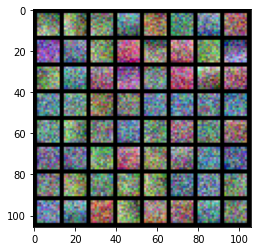

In [0]:
show_first_layer(net_no_pretrained)

torch.Size([64, 3, 11, 11])


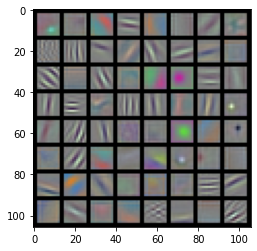

In [0]:
show_first_layer(net)

# 2. VGG

In [0]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo


model_urls = {
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth'
}


class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_chan = 3
    for name in cfg :
        if type(name) == int:
            layers.append(nn.Conv2d(in_chan, name, 3, padding=1))
            in_chan = name
            if batch_norm :
                layers.append(nn.BatchNorm2d(name))
            layers.append(nn.ReLU())
        elif name == 'M':
            layers.append(nn.MaxPool2d(2, stride=2))
    return nn.Sequential(*layers)

cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
}

In [0]:
def vgg_11_classifier(num_classes):
  classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes),
        )
  return classifier
  
def vgg11(num_classes, pretrained=False, **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['A'], batch_norm=True), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg11_bn']))
        for p in model.features.parameters():
            p.requires_grad=False
    model.classifier = vgg_11_classifier(num_classes)
    return model

In [0]:
vgg_no_pretrained = vgg11(num_classes=10, pretrained=False)

#net = AlexNet(10)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    vgg_no_pretrained.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(vgg_no_pretrained.parameters(),lr=learning_rate)
train(vgg_no_pretrained, optimizer, trainloader, testloader, criterion,  n_epoch = 50,
      train_acc_period = 10,
      test_acc_period = 1000)
accuracy(vgg_no_pretrained, testloader, cuda=use_cuda)

using cuda
[1,    10] loss: 0.035
[1,    10] acc: 0.129
[2,    10] loss: 0.032
[2,    10] acc: 0.162
[3,    10] loss: 0.031
[3,    10] acc: 0.174
[4,    10] loss: 0.031
[4,    10] acc: 0.196
[5,    10] loss: 0.030
[5,    10] acc: 0.206
[6,    10] loss: 0.030
[6,    10] acc: 0.239
[7,    10] loss: 0.030
[7,    10] acc: 0.239
[8,    10] loss: 0.029
[8,    10] acc: 0.238
[9,    10] loss: 0.028
[9,    10] acc: 0.244
[10,    10] loss: 0.029
[10,    10] acc: 0.224
[11,    10] loss: 0.028
[11,    10] acc: 0.241
[12,    10] loss: 0.027
[12,    10] acc: 0.268
[13,    10] loss: 0.028
[13,    10] acc: 0.279
[14,    10] loss: 0.026
[14,    10] acc: 0.294
[15,    10] loss: 0.027
[15,    10] acc: 0.275
[16,    10] loss: 0.026
[16,    10] acc: 0.287
[17,    10] loss: 0.027
[17,    10] acc: 0.276
[18,    10] loss: 0.026
[18,    10] acc: 0.293
[19,    10] loss: 0.024
[19,    10] acc: 0.353
[20,    10] loss: 0.026
[20,    10] acc: 0.323
[21,    10] loss: 0.024
[21,    10] acc: 0.353
[22,    10] loss: 0.

2010100.0

In [0]:
vgg = vgg11(num_classes=10, pretrained=True)

#net = AlexNet(10)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    vgg.cuda()
learning_rate = 1e-3
optimizer = torch.optim.Adam(vgg.parameters(),lr=learning_rate)
train(vgg, optimizer, trainloader, testloader, criterion,  n_epoch = 50,
      train_acc_period = 10,
      test_acc_period = 1000)
accuracy(vgg, testloader, cuda=use_cuda)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/checkpoints/vgg11_bn-6002323d.pth



using cuda
[1,    10] loss: 0.032
[1,    10] acc: 0.216
[2,    10] loss: 0.019
[2,    10] acc: 0.530
[3,    10] loss: 0.011
[3,    10] acc: 0.669
[4,    10] loss: 0.007
[4,    10] acc: 0.753
[5,    10] loss: 0.004
[5,    10] acc: 0.800
[6,    10] loss: 0.003
[6,    10] acc: 0.843
[7,    10] loss: 0.002
[7,    10] acc: 0.837
[8,    10] loss: 0.001
[8,    10] acc: 0.853
[9,    10] loss: 0.001
[9,    10] acc: 0.862
[10,    10] loss: 0.001
[10,    10] acc: 0.856
[11,    10] loss: 0.001
[11,    10] acc: 0.858
[12,    10] loss: 0.000
[12,    10] acc: 0.866
[13,    10] loss: 0.000
[13,    10] acc: 0.865
[14,    10] loss: 0.000
[14,    10] acc: 0.866
[15,    10] loss: 0.000
[15,    10] acc: 0.864
[16,    10] loss: 0.000
[16,    10] acc: 0.867
[17,    10] loss: 0.000
[17,    10] acc: 0.863
[18,    10] loss: 0.000
[18,    10] acc: 0.865
[19,    10] loss: 0.000
[19,    10] acc: 0.865
[20,    10] loss: 0.000
[20,    10] acc: 0.866
[21,    10] loss: 0.000
[21,    10] acc: 0.865
[22,    10] loss: 0

3625700.0

torch.Size([64, 3, 3, 3])


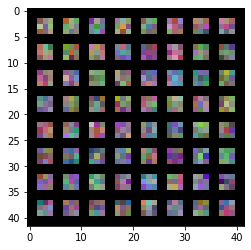

In [0]:
show_first_layer(vgg_no_pretrained)

torch.Size([64, 3, 3, 3])


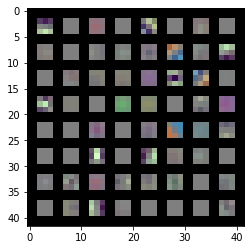

In [0]:
show_first_layer(vgg)

# 3. ResNet

In [0]:
def trainer(train_loader, test_loader, model, use_cuda, loss_fn=nn.CrossEntropyLoss(), epoch=10, rate=1e-3):
    loss_eval = []
    err_eval = []
    #   data = torch.utils.data.DataLoader(dataset, batch_size)
    optimizer = torch.optim.Adam(model.parameters(),lr=rate)
    j = 0
    for i in tqdm(range(epoch)):
        for imgs, labels in train_loader:
            j += 1
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.type(torch.cuda.FloatTensor)
                labels = labels.type(torch.cuda.LongTensor)

            optimizer.zero_grad()

            output = model(imgs)
            loss = loss_fn(output, labels)
            if j % 500 == 1 :
                loss_eval.append(loss.item())
                err_eval.append(1 - accuracy(test_loader, model, use_cuda))
            loss.backward()

            optimizer.step()
        
    return loss_eval, err_eval

def accuracy(dataloader, model, use_cuda):
    model.eval()
    #   test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
    corr = 0
    total = 0
    for imgs, labels in dataloader:
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
        with torch.no_grad():
            output = model(imgs)
            output = [torch.argmax(i) for i in output]
            correct = [i for i,j in zip(output, labels) if i == j]
            corr += len(correct)
            total += len(labels)
    model.train()
    # print(len(correct))
    return(corr / total)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SimpleBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(SimpleBlock, self).__init__()

        assert((stride == 1) or (stride == 2 and planes == in_planes * 2))

        padding = 0
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.conv2(out)
        out = F.relu(self.bn2(out))

        return out

      
class ResNetBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(ResNetBlock, self).__init__()

        assert((stride == 1) or (stride == 2 and planes == in_planes * 2))

        padding = 0
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, 3, stride=1, padding=1, bias=False)
        if stride == 2: 
            self.shortcut = nn.Conv2d(in_planes, planes, 1, stride=2, padding=0, bias=False)
        else: 
            self.shortcut = nn.Identity()
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.conv2(out) + self.shortcut(x)
        out = F.relu(self.bn2(out))

        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, num_filters=16, input_dim=3):
        super(ResNet, self).__init__()
        self.in_planes = num_filters

        self.conv1 = nn.Conv2d(input_dim, num_filters, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_filters)
		
        layers_resnet = []
        for i in range(len(num_blocks)) :
            if i == 0 :
                planes = self.in_planes
                print(planes)
                layers_resnet.append(self._make_layer(block, planes, num_blocks[i], stride=1))
            else :
                planes = self.in_planes * 2
                print(planes)
                layers_resnet.append(self._make_layer(block, planes, num_blocks[i], stride=2))

        self.resnet = nn.Sequential(*layers_resnet)
		
        self.fc = nn.Sequential(
            nn.Linear(self.in_planes, num_classes),
            nn.LogSoftmax(1)
        )

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []

        if stride != 1 :
            downsample = block(self.in_planes, planes, stride)
            layers.append(downsample)
            num_blocks -= 1
            self.in_planes = planes

        for i in range(num_blocks) :
            layers.append(block(self.in_planes, planes, 1))
            self.in_planes = planes
        
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.resnet(out)
        out = F.adaptive_avg_pool2d(out, (1,1))
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


# (1 + 2*(1 + 1) + 2*(1 + 1) + 2*(1 + 1) + 2*(1 + 1)) + 1 = 18
def ResNet18(input_dim=3):
    return ResNet(ResNetBlock, [6, 6, 6], input_dim=input_dim)

def PlainNet18(input_dim=3):
    return ResNet(SimpleBlock, [6, 6, 6], input_dim=input_dim)

## On CIFAR-10

In [0]:
batch_size=64
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
])
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=False)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=10000,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
model_resnet18 = ResNet18()
model_resnet18.apply(init)

#net = AlexNet(10)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    model_resnet18.cuda()
losses, val_errs = trainer(trainloader, testloader, model_resnet18, use_cuda, epoch=10)
print(accuracy(testloader, model_resnet18, use_cuda))

16
32
64
using cuda



0.7337


In [0]:
model_plainnet18 = PlainNet18()
model_plainnet18.apply(init)
#net = AlexNet(10)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    model_plainnet18.cuda()
losses_, val_errs_ = trainer(trainloader, testloader, model_plainnet18, use_cuda, epoch=10)
print(accuracy(testloader, model_plainnet18, use_cuda))


16
32
64
using cuda



0.6632


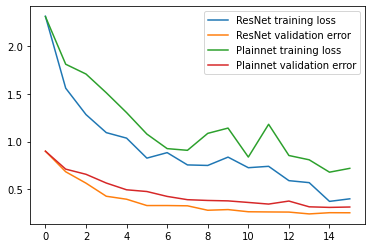

In [0]:
plt.plot(losses, label='ResNet training loss')
plt.plot(val_errs, label='ResNet validation error')
plt.plot(losses_, label='Plainnet training loss')
plt.plot(val_errs_, label='Plainnet validation error')
plt.legend()

## On FashionMNIST

In [0]:
batch_size=64
transform = transforms.Compose(
    [
     transforms.ToTensor()
])
trainset = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=False)
testset = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [0]:
model_resnet18 = ResNet18(1)
model_resnet18.apply(init)

#net = AlexNet(10)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    model_resnet18.cuda()
losses, val_errs = trainer(trainloader, testloader, model_resnet18, use_cuda, epoch=10)
print(accuracy(testloader, model_resnet18, use_cuda))

16
32

64
using cuda



0.9117


In [0]:
model_plainnet18 = PlainNet18(1)
model_plainnet18.apply(init)
#net = AlexNet(10)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    model_plainnet18.cuda()
losses_, val_errs_ = trainer(trainloader, testloader, model_plainnet18, use_cuda, epoch=10)
print(accuracy(testloader, model_plainnet18, use_cuda))

16
32
64
using cuda



0.9084


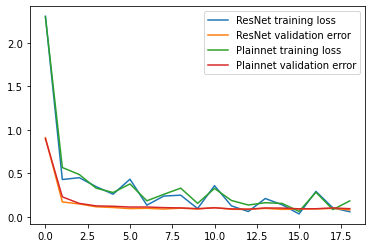

In [0]:
plt.plot(losses, label='ResNet training loss')
plt.plot(val_errs, label='ResNet validation error')
plt.plot(losses_, label='Plainnet training loss')
plt.plot(val_errs_, label='Plainnet validation error')
plt.legend()

The result is a lot better than a usual plain network. 

# 4. InceptionNet

In [0]:
import torch
import torch.nn as nn


class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        self.conv1 = nn.Sequential(
              nn.Conv2d(in_planes, kernel_1_x, 1),
              nn.BatchNorm2d(kernel_1_x),
              nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, 1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(),
            nn.Conv2d(kernel_3_in, kernel_3_x, 3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, 1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(),
            nn.Conv2d(kernel_5_in, kernel_5_x, 3, padding=1),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU()
        )
        self.pool = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, 1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU()
        )

    def forward(self, x):
        # print(self.conv1(x).shape)
        # print(self.conv3(x).shape)
        out = self.conv1(x)
        out = torch.cat((out, self.conv3(x)), 1)
        # print(out.shape)
        out = torch.cat((out, self.conv5(x)), 1)
        # print(out.shape)
        return torch.cat((out, self.pool(x)), 1)


class GoogLeNet(nn.Module):
    def __init__(self, input_dim=3):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(input_dim, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        
        self.layer1 = Inception(192,  64,  96, 128, 16, 32, 32)
        
        self.layer2 = Inception(256, 128, 128, 192, 32, 96, 64)
        
        self.layer3 = Inception(480, 192,  96, 208, 16,  48,  64)
        
        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(512, 10)
        

    def forward(self, x):
        x = self.pre_layers(x)
        x = self.layer1(x)
        x = self.max_pool(x)
        x = self.layer2(x)
        x = self.max_pool(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

## On CIFAR-10

In [0]:
batch_size=64
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,)),
])
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=False)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=1000,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
model_googlenet = GoogLeNet()
model_googlenet.apply(init)
#net = AlexNet(10)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    model_googlenet.cuda()
losses, val_errs = trainer(trainloader, testloader, model_googlenet, use_cuda, epoch=10)
print(accuracy(testloader, model_googlenet, use_cuda))


using cuda



0.7337


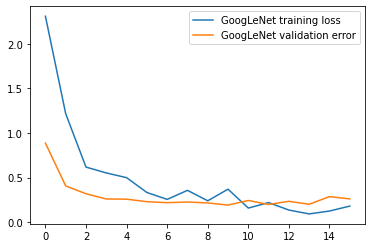

In [0]:
plt.plot(losses, label='GoogLeNet training loss')
plt.plot(val_errs, label='GoogLeNet validation error')
plt.legend()

## On FashionMNIST

In [0]:
batch_size=64
transform = transforms.Compose(
    [
     transforms.ToTensor()
])
trainset = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=False)
testset = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)


In [0]:
model_googlenet = GoogLeNet(1)
model_googlenet.apply(init)
#net = AlexNet(10)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    model_googlenet.cuda()
losses, val_errs = trainer(trainloader, testloader, model_googlenet, use_cuda, epoch=10)
print(accuracy(testloader, model_googlenet, use_cuda))

using cuda



0.8963


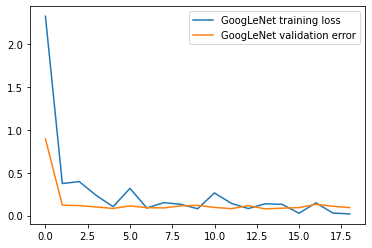

In [0]:
plt.plot(losses, label='GoogLeNet training loss')
plt.plot(val_errs, label='GoogLeNet validation error')
plt.legend()